<a href="https://colab.research.google.com/github/jaclynchiu7/EEG-Analysis/blob/main/EEG_VAE_details.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Data


In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs260/assignments/assignment4/'
FOLDERNAME = 'Personal Coding projects/ecengr 247'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt


In [5]:
X_test = np.load("drive/MyDrive/Personal Coding projects/EEG project/X_test.npy")
y_test = np.load("drive/MyDrive/Personal Coding projects/EEG project/y_test.npy")
person_train_valid = np.load("drive/MyDrive/Personal Coding projects/EEG project/person_train_valid.npy")
X_train_valid = np.load("drive/MyDrive/Personal Coding projects/EEG project/X_train_valid.npy")
y_train_valid = np.load("drive/MyDrive/Personal Coding projects/EEG project/y_train_valid.npy")
person_test = np.load("drive/MyDrive/Personal Coding projects/EEG project/person_test.npy")


In [ ]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [ ]:
# remap test labels 
# 0: left hand, 1: right hand, 2: feet, 3: tongue 
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_train_valid = label_encoder.fit_transform(y_train_valid)
y_test = label_encoder.fit_transform(y_test)

# Preprocessing Data

### Data Preprocessing

In [ ]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


# X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)


### Generating Training and Validation Data

In [ ]:
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


## Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)


print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of testing set: (1772, 22, 250)
Shape of testing labels: (1772,)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)


# Variational AutoEncoder (VAE)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle

#### Check GPU

In [ ]:
!nvidia-smi # check for GPU

Wed Mar 15 17:31:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#### VAE architecture

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Encoder 

latent_dim = 8
encoder_inputs = keras.Input(shape=(22, 250, 1), name='input_layer')
 
# Block-1
x = layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(encoder_inputs)
x = layers.BatchNormalization(name='bn_1')(x)
x = layers.LeakyReLU(name='lrelu_1')(x)
  
# Block-2
x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
x = layers.BatchNormalization(name='bn_2')(x)
x = layers.LeakyReLU(name='lrelu_2')(x)
  
# Block-3
x = layers.Conv2D(64, 3, 1, padding='same', name='conv_3')(x)
x = layers.BatchNormalization(name='bn_3')(x)
x = layers.LeakyReLU(name='lrelu_3')(x)

# Block-4
x = layers.Conv2D(64, 3, 1, padding='same', name='conv_4')(x)
x = layers.BatchNormalization(name='bn_4')(x)
x = layers.LeakyReLU(name='lrelu_4')(x)

# Final Block
flatten = layers.Flatten()(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 22, 250, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv_1 (Conv2D)                (None, 22, 250, 32)  320         ['input_layer[0][0]']            
                                                                                                  
 bn_1 (BatchNormalization)      (None, 22, 250, 32)  128         ['conv_1[0][0]']                 
                                                                                                  
 lrelu_1 (LeakyReLU)            (None, 22, 250, 32)  0           ['bn_1[0][0]']             

In [ ]:
# Decoder 

latent_inputs = keras.Input(shape=(latent_dim,), name='input_layer')
x = layers.Dense(11*125*64, name='dense_1')(latent_inputs)
x = layers.Reshape((11, 125, 64), name='Reshape_Layer')(x)

# Block-1
x = layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(x)
x = layers.BatchNormalization(name='bn_1')(x)
x = layers.LeakyReLU(name='lrelu_1')(x)

# Block-2
x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
x = layers.BatchNormalization(name='bn_2')(x)
x = layers.LeakyReLU(name='lrelu_2')(x)
  
# Block-3
x = layers.Conv2DTranspose(32, 3, 1, padding='same', name='conv_transpose_3')(x)
x = layers.BatchNormalization(name='bn_3')(x)
x = layers.LeakyReLU(name='lrelu_3')(x)
  
# Block-4
decoder_outputs = layers.Conv2DTranspose(1, 3, 1,padding='same', activation='elu', name='conv_transpose_4')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 8)]               0         
                                                                 
 dense_1 (Dense)             (None, 88000)             792000    
                                                                 
 Reshape_Layer (Reshape)     (None, 11, 125, 64)       0         
                                                                 
 conv_transpose_1 (Conv2DTra  (None, 11, 125, 64)      36928     
 nspose)                                                         
                                                                 
 bn_1 (BatchNormalization)   (None, 11, 125, 64)       256       
                                                                 
 lrelu_1 (LeakyReLU)         (None, 11, 125, 64)       0         
                                                           

In [ ]:
class VAE(keras.Model): # VAE class 
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.mse_loss_tracker = keras.metrics.Mean(
            name="mse_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.mse_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            mse_loss = tf.keras.backend.mean(tf.keras.backend.square(data-reconstruction), axis=[1, 2, 3])
            mse_loss *= 1000 #  scaling
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = mse_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.mse_loss_tracker.update_state(mse_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "mse_loss": self.mse_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

#### Training VAE per class 


In [ ]:
# Class 0
class_0_idx = np.where(y_train == 0)[0]

X_train_class_0 = x_train[class_0_idx, :, :]
y_train_class_0= y_train[class_0_idx]

print ('Training/Valid data shape: {}'.format(X_train_class_0.shape))
print ('Training/Valid target shape: {}'.format(y_train_class_0.shape))
x_class0 = np.expand_dims(X_train_class_0, -1).astype("float32")/255.0

Training/Valid data shape: (1736, 22, 250)
Training/Valid target shape: (1736,)


In [ ]:
vae_class0 = VAE(encoder, decoder)
vae_class0.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0005))
with tf.device('/device:GPU:0'):
  vae_class0.fit(x_class0, epochs = 10)

Epoch 1/10
55/55 [==============================] - 19s 47ms/step - loss: 1.7170 - mse_loss: 1.6622 - kl_loss: 8.2126e-05
Epoch 2/10
55/55 [==============================] - 2s 39ms/step - loss: 1.6217 - mse_loss: 1.6271 - kl_loss: 8.8643e-06
Epoch 3/10
55/55 [==============================] - 2s 39ms/step - loss: 1.6416 - mse_loss: 1.6257 - kl_loss: 5.1347e-06
Epoch 4/10
55/55 [==============================] - 2s 39ms/step - loss: 1.6191 - mse_loss: 1.6238 - kl_loss: 4.6876e-06
Epoch 5/10
55/55 [==============================] - 2s 41ms/step - loss: 1.6139 - mse_loss: 1.6215 - kl_loss: 3.3725e-06
Epoch 6/10
55/55 [==============================] - 2s 40ms/step - loss: 1.5856 - mse_loss: 1.6212 - kl_loss: 3.7074e-06
Epoch 7/10
55/55 [==============================] - 2s 40ms/step - loss: 1.6226 - mse_loss: 1.6212 - kl_loss: 2.8117e-06
Epoch 8/10
55/55 [==============================] - 2s 39ms/step - loss: 1.6196 - mse_loss: 1.6211 - kl_loss: 2.2422e-06
Epoch 9/10
55/55 [=============

In [ ]:
# generating new class 0 data  
z_mean, _, _ = vae_class0.encoder.predict(x_class0)
x_train_vae_class0 = vae_class0.decoder.predict(z_mean)
y_train_vae_class0 = np.zeros(len(y_train_class_0))
print(x_train_vae_class0.shape)
print(y_train_vae_class0.shape)

55/55 [==============================] - 1s 8ms/step
(1736, 22, 250, 1)
(1736,)


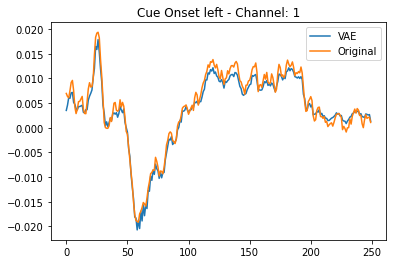

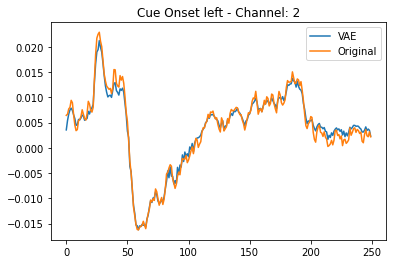

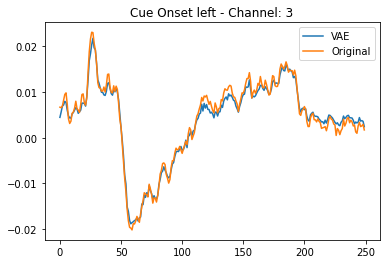

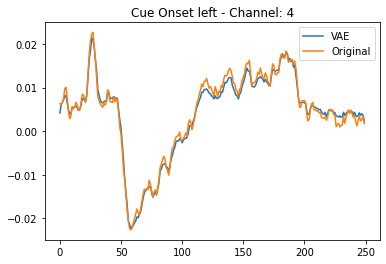

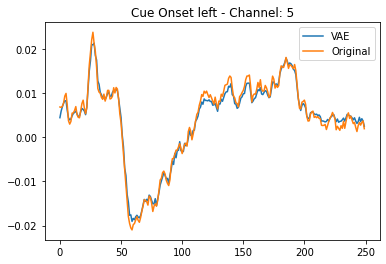

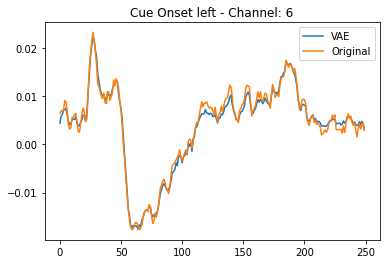

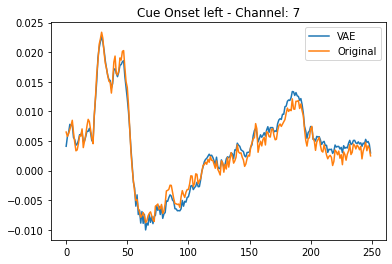

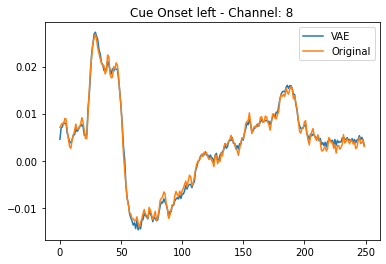

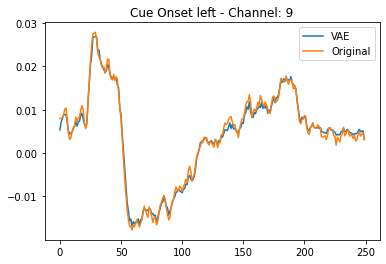

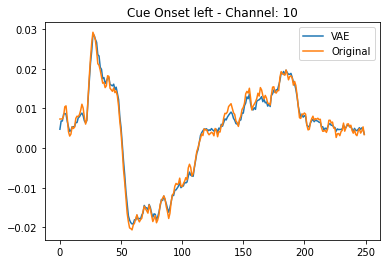

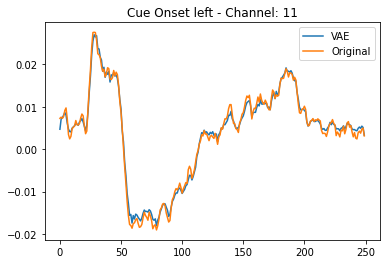

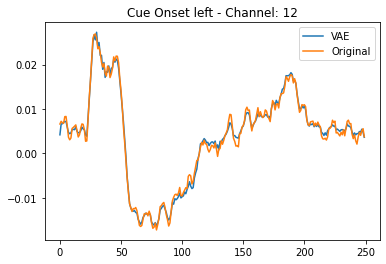

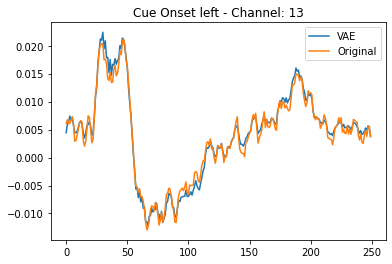

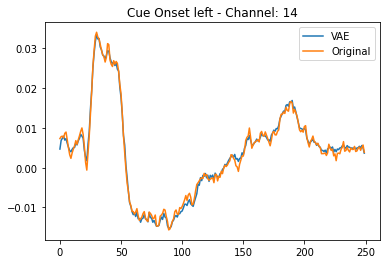

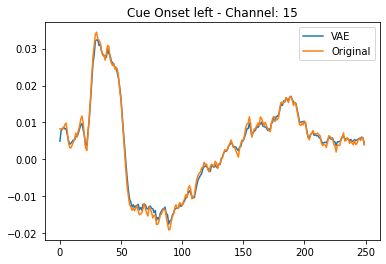

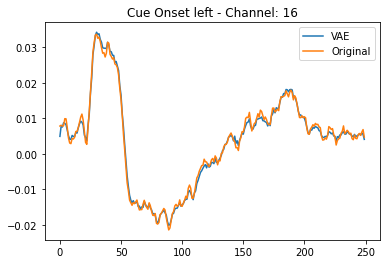

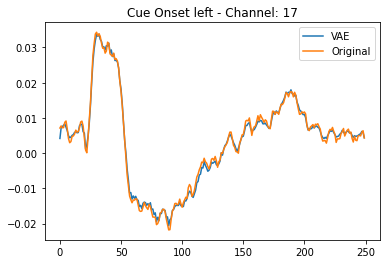

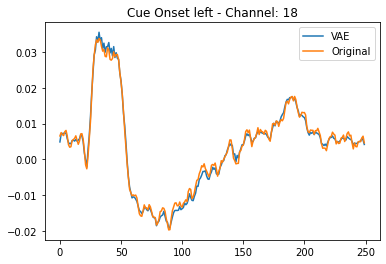

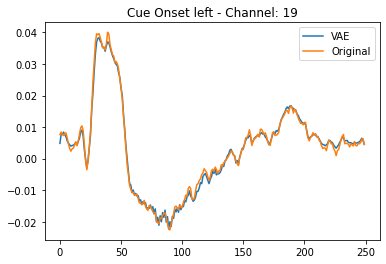

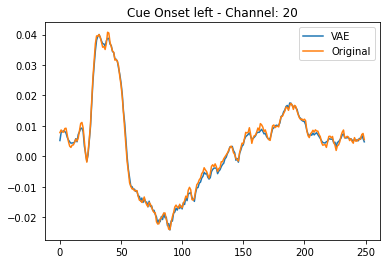

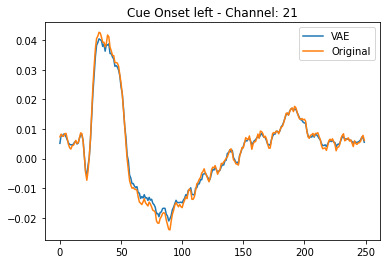

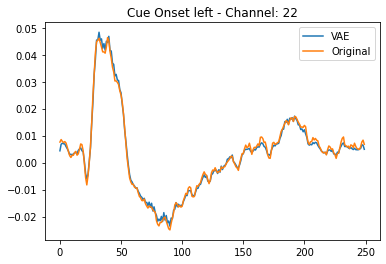

In [ ]:
# comparing VAE and Training for Class 0
for i in range(22):
  #### VAE
  avg_ch_data_class_0_vae = np.mean(x_train_vae_class0[:,i,:],axis=0)
  avg_ch_data_class_0 = np.mean(x_class0[:,i,:],axis=0)

  plt.figure()
  plt.plot(np.arange(250),avg_ch_data_class_0_vae)
  plt.plot(np.arange(250),avg_ch_data_class_0)
  plt.legend(["VAE", "Original"])
  plt.title("Cue Onset left - Channel: " + str(i+1))
  plt.show()


In [ ]:
# Class 1
class_1_idx = np.where(y_train == 1)[0]

X_train_class_1 = x_train[class_1_idx, :, :]
y_train_class_1= y_train[class_1_idx]

print ('Training/Valid data shape: {}'.format(X_train_class_1.shape))
print ('Training/Valid target shape: {}'.format(y_train_class_1.shape))
x_class1 = np.expand_dims(X_train_class_1, -1).astype("float32")/255.0

Training/Valid data shape: (1700, 22, 250)
Training/Valid target shape: (1700,)


In [ ]:
vae_class1 = VAE(encoder, decoder)
vae_class1.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0005))
with tf.device('/device:GPU:0'):
  vae_class1.fit(x_class1, epochs = 10)

Epoch 1/10
54/54 [==============================] - 8s 46ms/step - loss: 1.5766 - mse_loss: 1.5830 - kl_loss: 5.1779e-06
Epoch 2/10
54/54 [==============================] - 2s 40ms/step - loss: 1.5777 - mse_loss: 1.5797 - kl_loss: 2.7170e-06
Epoch 3/10
54/54 [==============================] - 2s 39ms/step - loss: 1.6026 - mse_loss: 1.5774 - kl_loss: 2.7517e-06
Epoch 4/10
54/54 [==============================] - 2s 40ms/step - loss: 1.5684 - mse_loss: 1.5773 - kl_loss: 3.1348e-06
Epoch 5/10
54/54 [==============================] - 2s 42ms/step - loss: 1.5721 - mse_loss: 1.5767 - kl_loss: 2.7015e-06
Epoch 6/10
54/54 [==============================] - 2s 41ms/step - loss: 1.5959 - mse_loss: 1.5767 - kl_loss: 2.3627e-06
Epoch 7/10
54/54 [==============================] - 2s 40ms/step - loss: 1.6023 - mse_loss: 1.5761 - kl_loss: 2.1822e-06
Epoch 8/10
54/54 [==============================] - 2s 40ms/step - loss: 1.5732 - mse_loss: 1.5769 - kl_loss: 1.8395e-06
Epoch 9/10
54/54 [==============

In [ ]:
# generating new class 1 data  
z_mean, _, _ = vae_class1.encoder.predict(x_class1)
x_train_vae_class1 = vae_class1.decoder.predict(z_mean)
y_train_vae_class1 = np.ones(len(y_train_class_1))
print(x_train_vae_class1.shape)
print(y_train_vae_class1.shape)

54/54 [==============================] - 0s 8ms/step
(1700, 22, 250, 1)
(1700,)


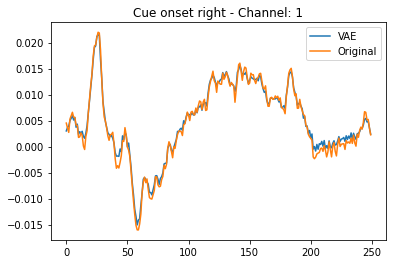

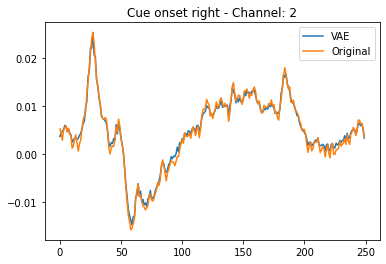

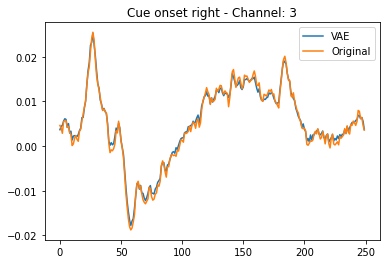

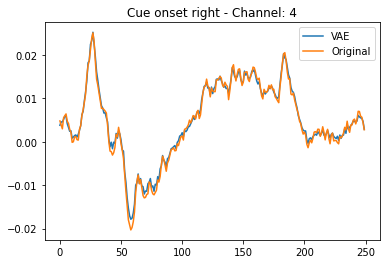

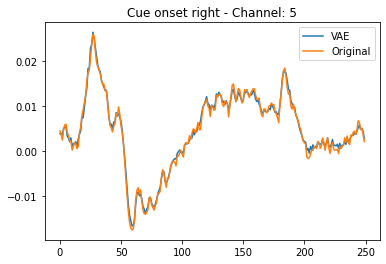

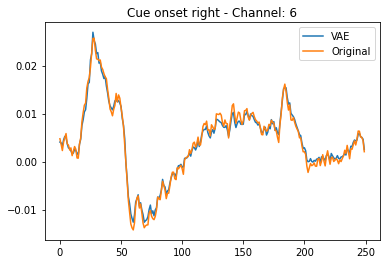

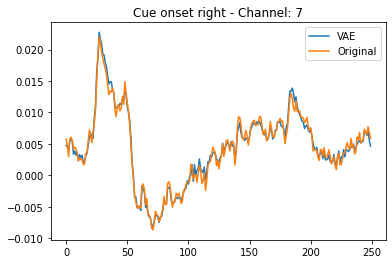

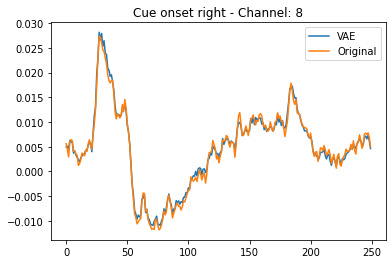

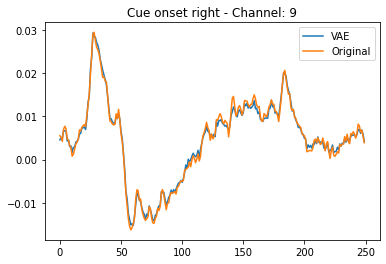

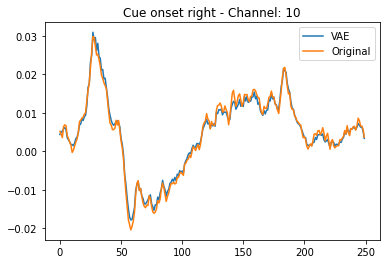

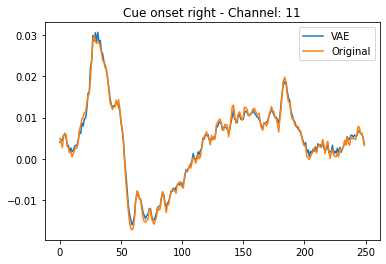

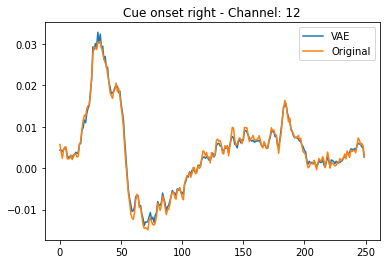

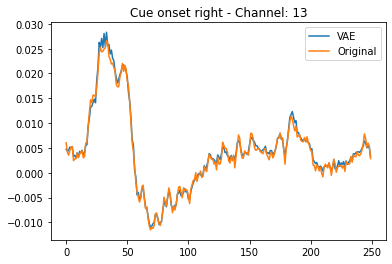

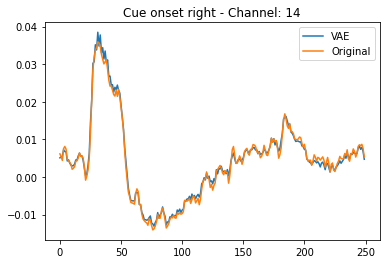

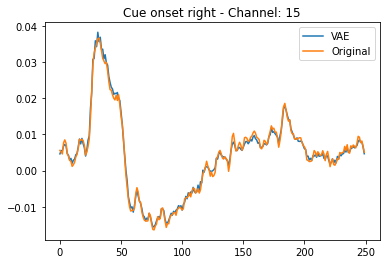

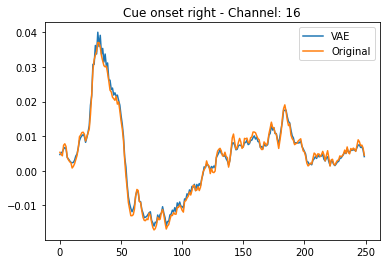

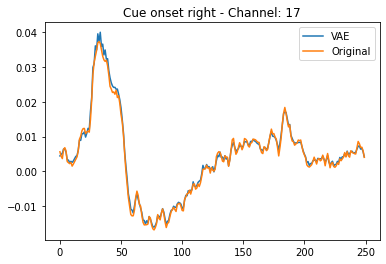

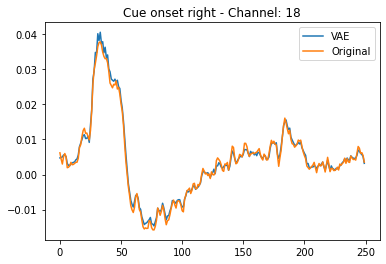

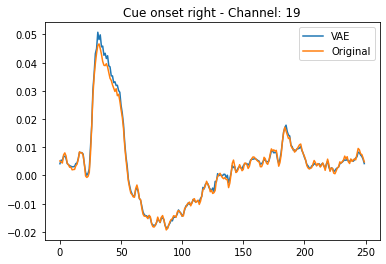

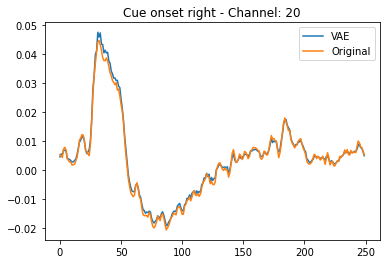

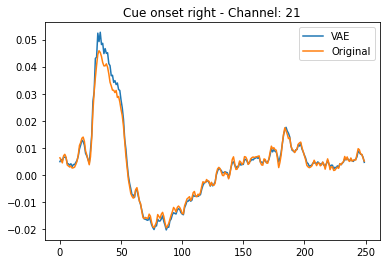

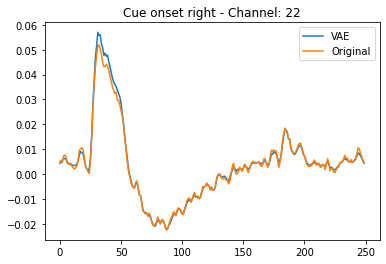

In [ ]:
# comparing VAE and Training for Class 1
for i in range(22):
  #### VAE
  avg_ch_data_class_1_vae = np.mean(x_train_vae_class1[:,i,:],axis=0)
  avg_ch_data_class_1 = np.mean(x_class1[:,i,:],axis=0)

  plt.figure()
  plt.plot(np.arange(250),avg_ch_data_class_1_vae)
  plt.plot(np.arange(250),avg_ch_data_class_1)
  plt.legend(["VAE", "Original"])
  plt.title("Cue onset right - Channel: " + str(i+1))
  plt.show()

In [ ]:
# Class 2
class_2_idx = np.where(y_train == 2)[0]

X_train_class_2 = x_train[class_2_idx, :, :]
y_train_class_2= y_train[class_2_idx]

print ('Training/Valid data shape: {}'.format(X_train_class_2.shape))
print ('Training/Valid target shape: {}'.format(y_train_class_2.shape))
x_class2 = np.expand_dims(X_train_class_2, -1).astype("float32")/255.0

Training/Valid data shape: (1800, 22, 250)
Training/Valid target shape: (1800,)


In [ ]:
vae_class2 = VAE(encoder, decoder)
vae_class2.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0005))
with tf.device('/device:GPU:0'):
  vae_class2.fit(x_class2, epochs = 10)

Epoch 1/10
57/57 [==============================] - 8s 42ms/step - loss: 1.7301 - mse_loss: 1.7257 - kl_loss: 7.1311e-06
Epoch 2/10
57/57 [==============================] - 2s 41ms/step - loss: 1.6906 - mse_loss: 1.7201 - kl_loss: 3.3441e-06
Epoch 3/10
57/57 [==============================] - 2s 41ms/step - loss: 1.7267 - mse_loss: 1.7192 - kl_loss: 2.9645e-06
Epoch 4/10
57/57 [==============================] - 2s 40ms/step - loss: 1.7117 - mse_loss: 1.7178 - kl_loss: 1.8702e-06
Epoch 5/10
57/57 [==============================] - 2s 41ms/step - loss: 1.6970 - mse_loss: 1.7168 - kl_loss: 2.2613e-06
Epoch 6/10
57/57 [==============================] - 2s 42ms/step - loss: 1.7293 - mse_loss: 1.7159 - kl_loss: 1.7725e-06
Epoch 7/10
57/57 [==============================] - 2s 42ms/step - loss: 1.7171 - mse_loss: 1.7180 - kl_loss: 2.4851e-06
Epoch 8/10
57/57 [==============================] - 3s 44ms/step - loss: 1.6732 - mse_loss: 1.7164 - kl_loss: 1.6031e-06
Epoch 9/10
57/57 [==============

In [ ]:
# generating new class 2 data  
z_mean, _, _ = vae_class2.encoder.predict(x_class2)
x_train_vae_class2 = vae_class2.decoder.predict(z_mean)
y_train_vae_class2 = np.ones(len(y_train_class_2)) * 2
print(x_train_vae_class2.shape)
print(y_train_vae_class2.shape)

57/57 [==============================] - 0s 8ms/step
(1800, 22, 250, 1)
(1800,)


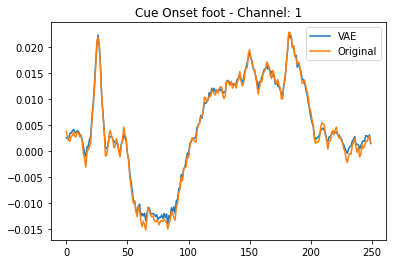

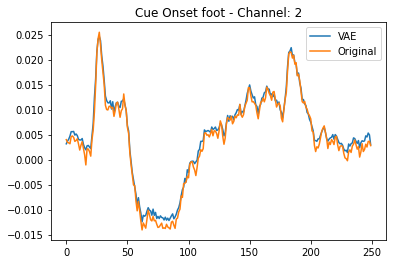

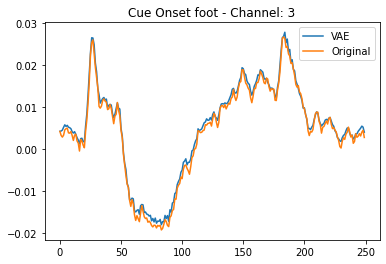

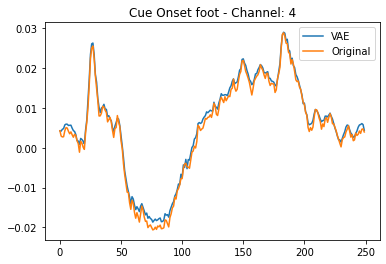

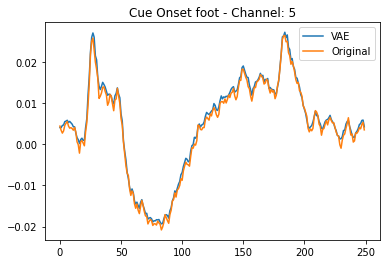

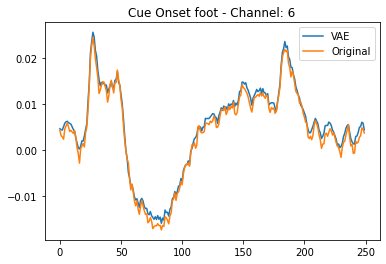

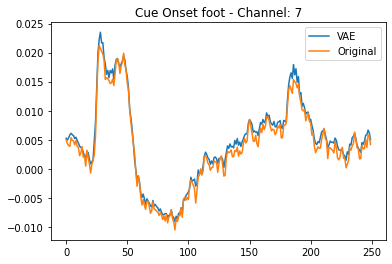

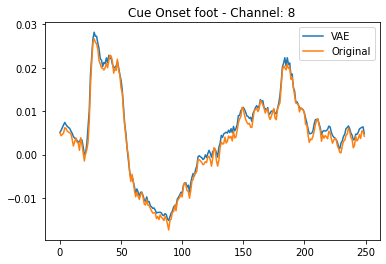

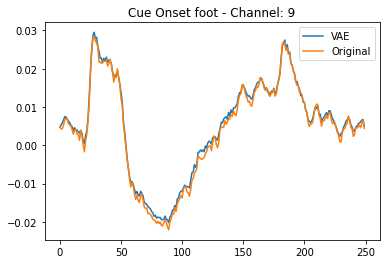

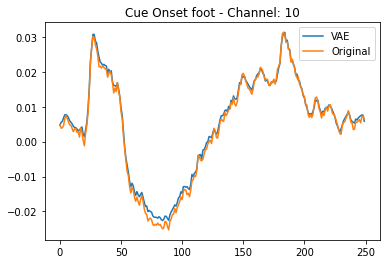

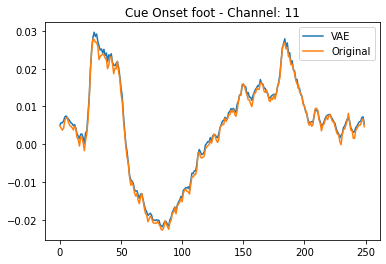

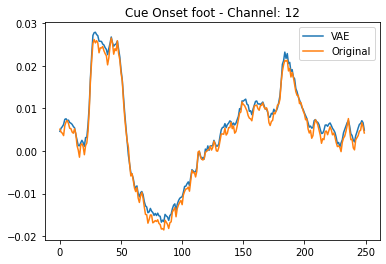

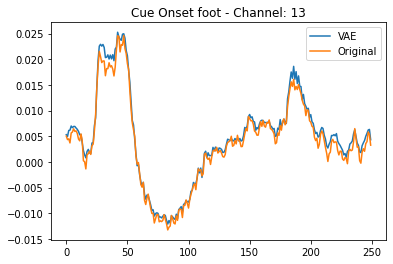

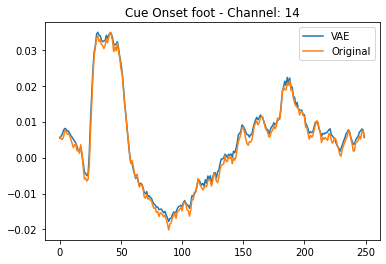

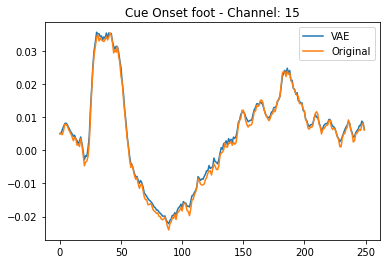

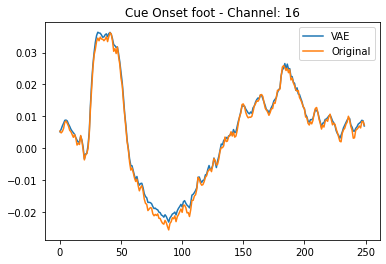

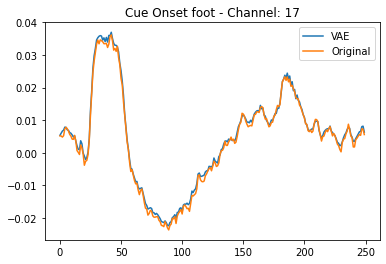

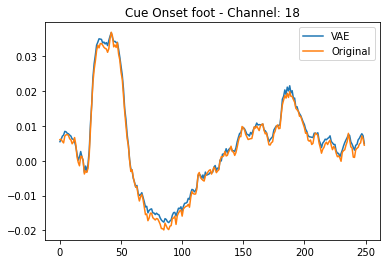

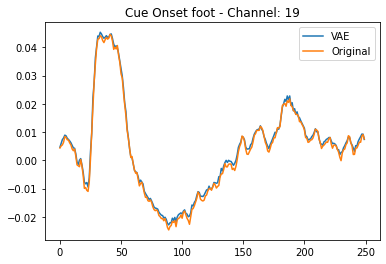

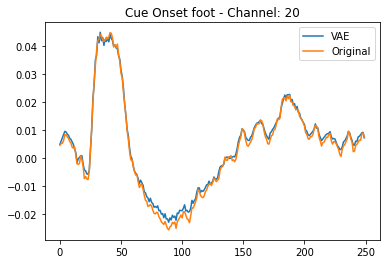

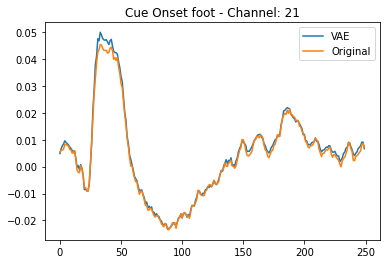

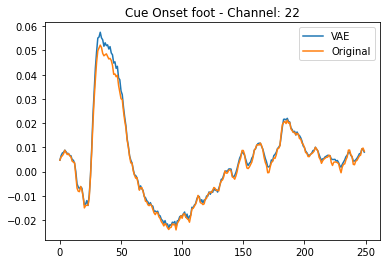

In [ ]:
# comparing VAE and Training for Class 2
for i in range(22):
  #### VAE
  avg_ch_data_class_2_vae = np.mean(x_train_vae_class2[:,i,:],axis=0)
  avg_ch_data_class_2 = np.mean(x_class2[:,i,:],axis=0)

  plt.figure()
  plt.plot(np.arange(250),avg_ch_data_class_2_vae)
  plt.plot(np.arange(250),avg_ch_data_class_2)
  plt.legend(["VAE", "Original"])
  plt.title("Cue Onset foot - Channel: " + str(i+1))
  plt.show()

In [ ]:
# Class 3
class_3_idx = np.where(y_train == 3)[0]

X_train_class_3 = x_train[class_3_idx, :, :]
y_train_class_3= y_train[class_3_idx]

print ('Training/Valid data shape: {}'.format(X_train_class_3.shape))
print ('Training/Valid target shape: {}'.format(y_train_class_3.shape))
x_class3 = np.expand_dims(X_train_class_3, -1).astype("float32")/255.0


Training/Valid data shape: (1724, 22, 250)
Training/Valid target shape: (1724,)


In [ ]:
vae_class3 = VAE(encoder, decoder)
vae_class3.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0005))
with tf.device('/device:GPU:0'):
  vae_class3.fit(x_class3, epochs = 10)

Epoch 1/10
54/54 [==============================] - 8s 54ms/step - loss: 1.7703 - mse_loss: 1.7505 - kl_loss: 2.8991e-06
Epoch 2/10
54/54 [==============================] - 2s 40ms/step - loss: 1.7761 - mse_loss: 1.7429 - kl_loss: 2.5304e-06
Epoch 3/10
54/54 [==============================] - 2s 40ms/step - loss: 1.7541 - mse_loss: 1.7417 - kl_loss: 2.8290e-06
Epoch 4/10
54/54 [==============================] - 2s 41ms/step - loss: 1.7338 - mse_loss: 1.7408 - kl_loss: 1.4504e-06
Epoch 5/10
54/54 [==============================] - 2s 41ms/step - loss: 1.7466 - mse_loss: 1.7410 - kl_loss: 1.9267e-06
Epoch 6/10
54/54 [==============================] - 2s 42ms/step - loss: 1.7619 - mse_loss: 1.7426 - kl_loss: 2.5260e-06
Epoch 7/10
54/54 [==============================] - 2s 41ms/step - loss: 1.7422 - mse_loss: 1.7413 - kl_loss: 1.5983e-06
Epoch 8/10
54/54 [==============================] - 2s 40ms/step - loss: 1.7084 - mse_loss: 1.7413 - kl_loss: 1.5271e-06
Epoch 9/10
54/54 [==============

In [ ]:
# generating new class 3 data  
z_mean, _, _ = vae_class3.encoder.predict(x_class3)
x_train_vae_class3 = vae_class3.decoder.predict(z_mean)
y_train_vae_class3 = np.ones(len(y_train_class_3)) * 3
print(x_train_vae_class3.shape)
print(y_train_vae_class3.shape)

54/54 [==============================] - 0s 8ms/step
(1724, 22, 250, 1)
(1724,)


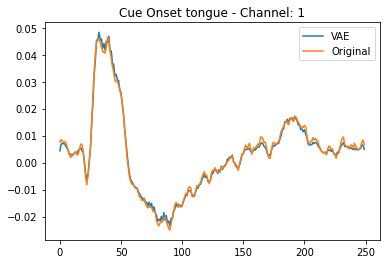

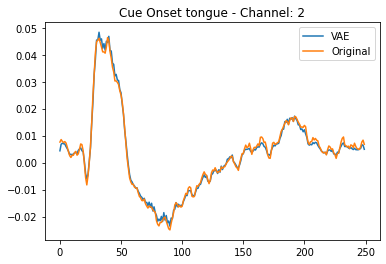

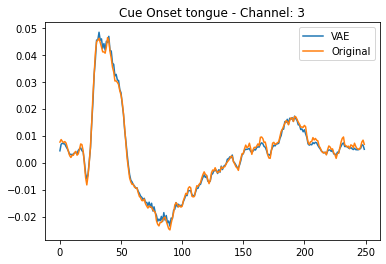

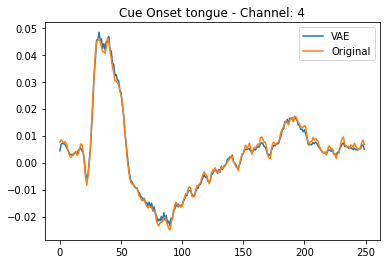

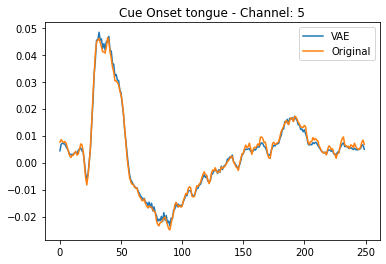

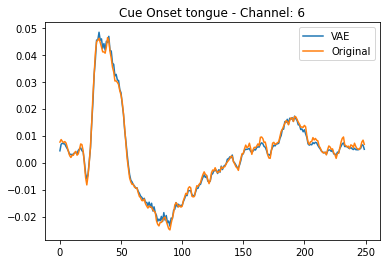

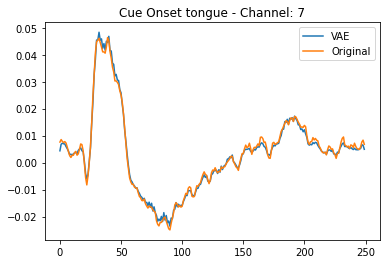

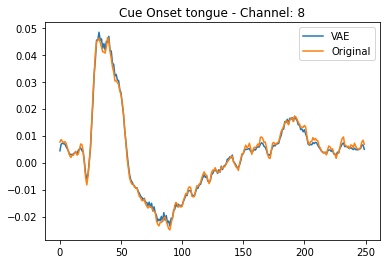

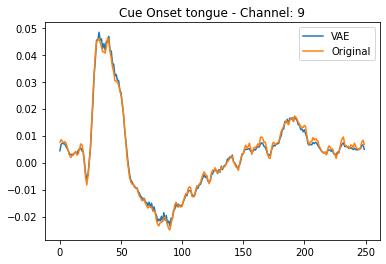

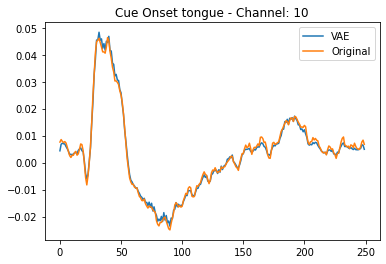

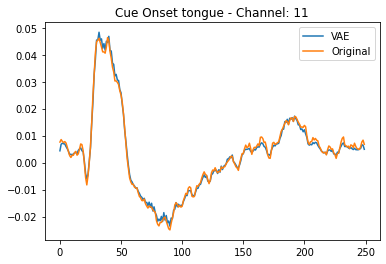

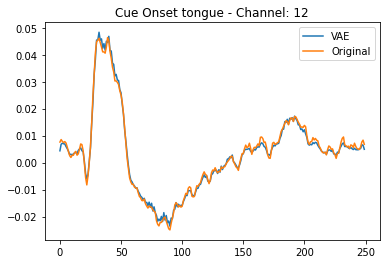

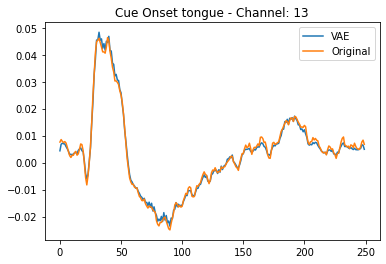

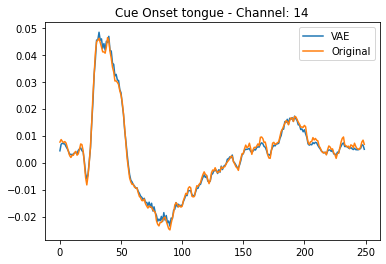

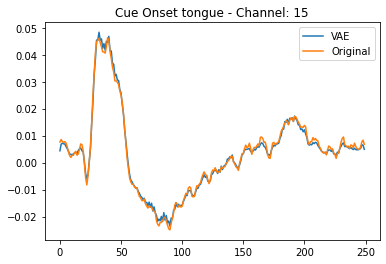

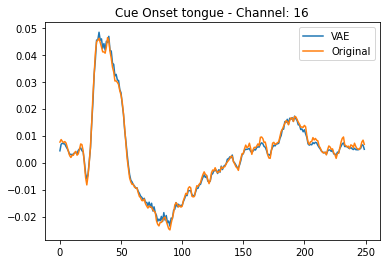

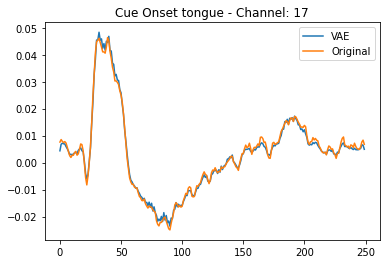

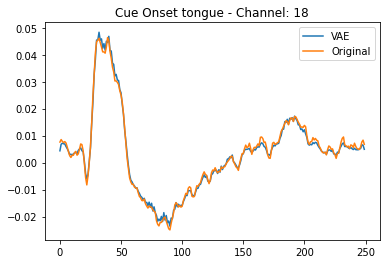

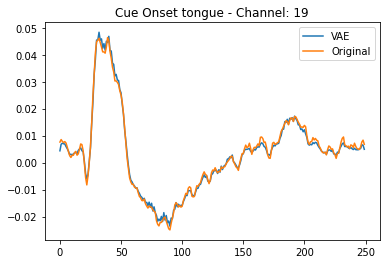

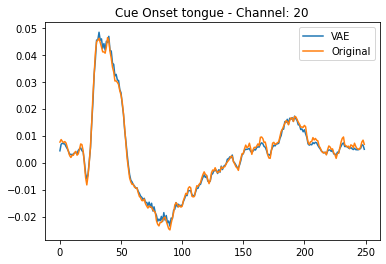

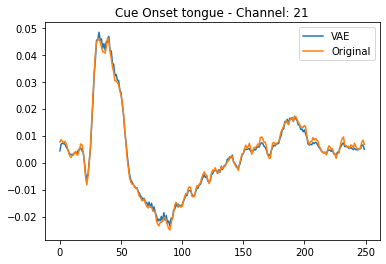

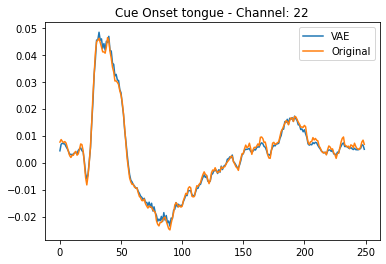

In [ ]:
# comparing VAE and Training for Class 3
for i in range(22):
  #### VAE
  avg_ch_data_class_3_vae = np.mean(x_train_vae_class3[:,i,:],axis=0)
  avg_ch_data_class_3 = np.mean(x_class3[:,i,:],axis=0)

  plt.figure()
  plt.plot(np.arange(250),avg_ch_data_class_0_vae)
  plt.plot(np.arange(250),avg_ch_data_class_0)
  plt.legend(["VAE", "Original"])
  plt.title("Cue Onset tongue - Channel: " + str(i+1))
  plt.show()

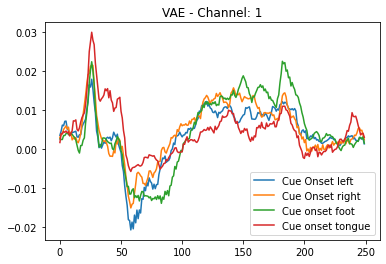

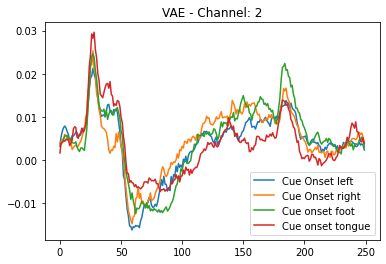

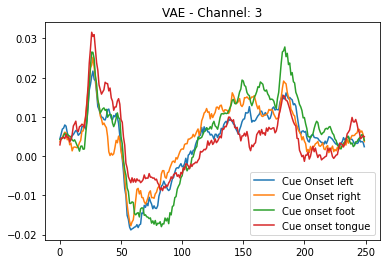

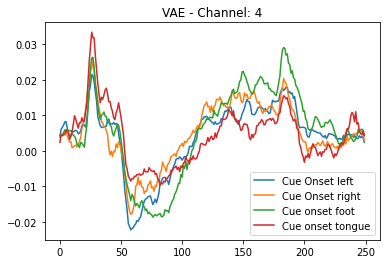

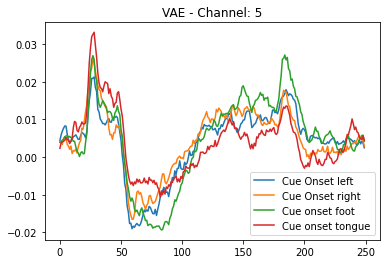

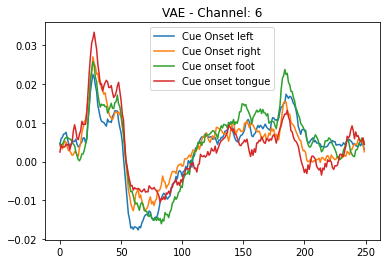

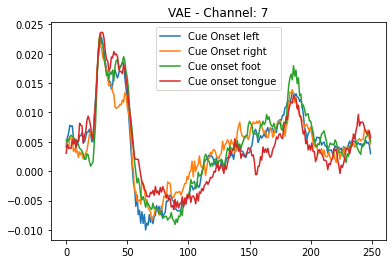

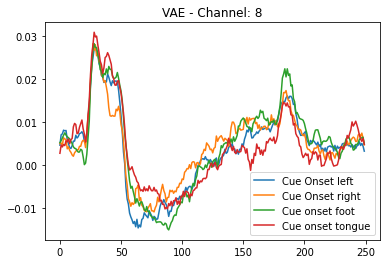

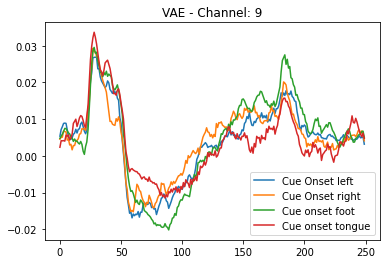

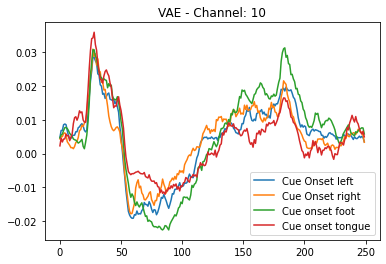

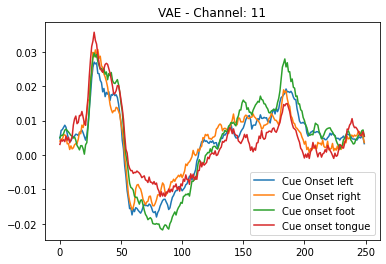

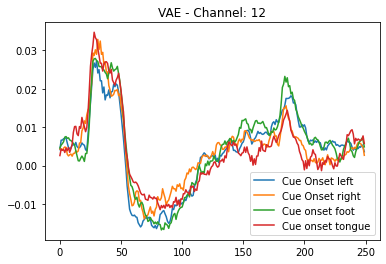

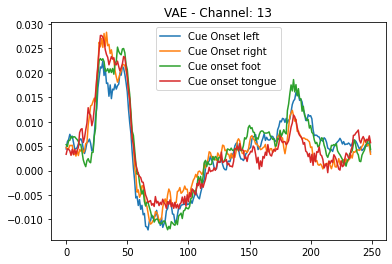

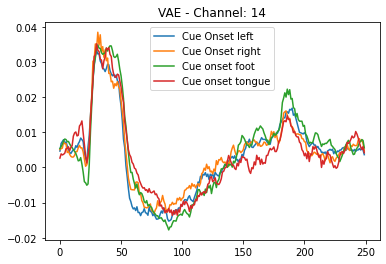

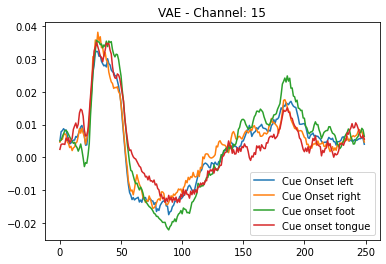

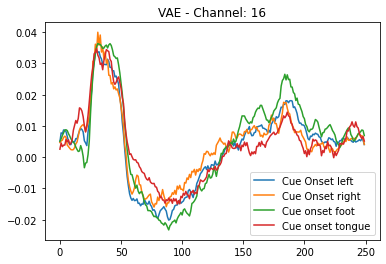

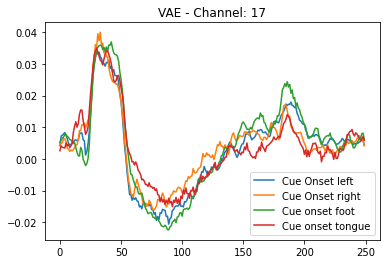

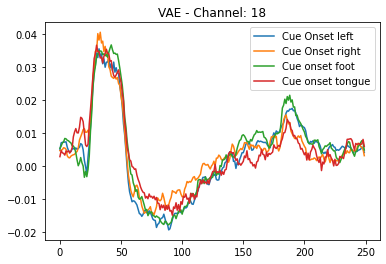

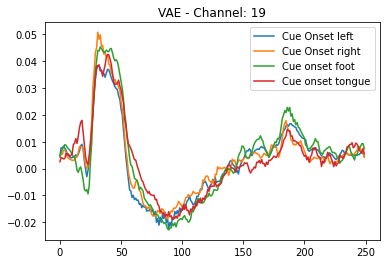

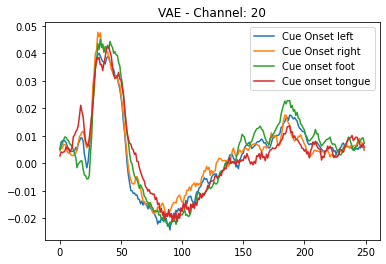

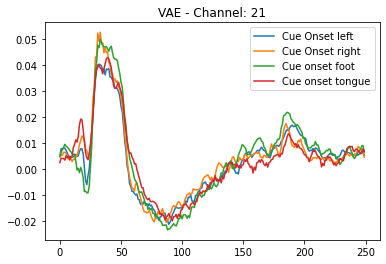

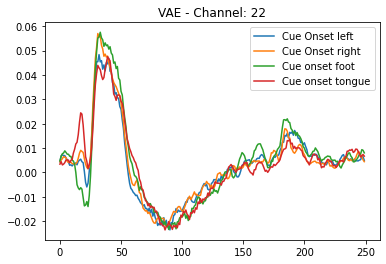

In [ ]:
# Comparing VAE across channels 

for i in range(22):
  #### VAE
  avg_ch_data_class_0_vae = np.mean(x_train_vae_class0[:,i,:],axis=0)
  avg_ch_data_class_1_vae = np.mean(x_train_vae_class1[:,i,:],axis=0)
  avg_ch_data_class_2_vae = np.mean(x_train_vae_class2[:,i,:],axis=0)
  avg_ch_data_class_3_vae = np.mean(x_train_vae_class3[:,i,:],axis=0)

  plt.figure()
  plt.plot(np.arange(250),avg_ch_data_class_0_vae)
  plt.plot(np.arange(250),avg_ch_data_class_1_vae)
  plt.plot(np.arange(250),avg_ch_data_class_2_vae)
  plt.plot(np.arange(250),avg_ch_data_class_3_vae)
  plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])
  plt.title("VAE - Channel: " + str(i+1))
  plt.show()

#### Concatenating VAE new data 

In [ ]:
# stacking X data
vae_X = np.vstack((x_train_vae_class0, x_train_vae_class1))
vae_X = np.vstack((vae_X , x_train_vae_class2))
vae_X = np.vstack((vae_X , x_train_vae_class3))

# stacking Y data
vae_y = np.hstack((y_train_vae_class0, y_train_vae_class1))
vae_y = np.hstack((vae_y, y_train_vae_class2))
vae_y = np.hstack((vae_y, y_train_vae_class3))

print ('Training VAE data shape: {}'.format(vae_X.shape))
print ('Training VAE target shape: {}'.format(vae_y.shape))

Training VAE data shape: (6960, 22, 250, 1)
Training VAE target shape: (6960,)


In [ ]:
# shuffling new VAE data
from sklearn.utils import shuffle
vae_X, vae_y = shuffle(vae_X, vae_y)

In [ ]:
vae_X = vae_X.reshape(vae_X.shape[0], vae_X.shape[1], vae_X.shape[2]) # reshaping to original train data 
x_train = np.vstack((x_train, vae_X))
y_train = np.hstack((y_train, vae_y))
print('Shape of training labels after VAE data augmentation:',x_train.shape)
print('Shape of training data after VAE data augmentation:',y_train.shape)

Shape of training labels after VAE data augmentation: (13920, 22, 250)
Shape of training data after VAE data augmentation: (13920,)


Concatenating VAE and original data

#### VAE function

In [ ]:

def VAE_augmentation(X,y):
    
    total_X = X
    total_y = y

    # Class 0 VAE generation 
    class_0_idx = np.where(y == 0)[0]
    X_train_class_0 = X[class_0_idx, :, :]
    y_train_class_0= y[class_0_idx]
    x_class0 = np.expand_dims(X_train_class_0, -1).astype("float32")/255.0
    vae_class0 = VAE(encoder, decoder)
    vae_class0.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0005))
    with tf.device('/device:GPU:0'):
      vae_class0.fit(x_class0, epochs = 10)
    
    z_mean, _, _ = vae_class0.encoder.predict(x_class0)
    x_train_vae_class0 = vae_class0.decoder.predict(z_mean)
    y_train_vae_class0 = np.zeros(len(y_train_class_0))

    # Class 1 VAE generation 
    class_1_idx = np.where(y == 1)[0]
    X_train_class_1 = X[class_1_idx, :, :]
    y_train_class_1= y[class_1_idx]
    x_class1 = np.expand_dims(X_train_class_1, -1).astype("float32")/255.0
    vae_class1 = VAE(encoder, decoder)
    vae_class1.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0005))
    with tf.device('/device:GPU:0'):
      vae_class1.fit(x_class1, epochs = 10)
    
    z_mean, _, _ = vae_class1.encoder.predict(x_class1)
    x_train_vae_class1 = vae_class1.decoder.predict(z_mean)
    y_train_vae_class1 = np.zeros(len(y_train_class_1))

    # Class 2 VAE generation 
    class_2_idx = np.where(y == 2)[0]

    X_train_class_2 = X[class_2_idx, :, :]
    y_train_class_2= y[class_2_idx]
    x_class2 = np.expand_dims(X_train_class_2, -1).astype("float32")/255.0
    vae_class2 = VAE(encoder, decoder)
    vae_class2.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0005))
    with tf.device('/device:GPU:0'):
      vae_class2.fit(x_class2, epochs = 10)
    
    z_mean, _, _ = vae_class2.encoder.predict(x_class2)
    x_train_vae_class2 = vae_class2.decoder.predict(z_mean)
    y_train_vae_class2 = np.zeros(len(y_train_class_2))

    # Class 3 VAE generation 
    class_3_idx = np.where(y == 3)[0]

    X_train_class_3 = X[class_3_idx, :, :]
    y_train_class_3= y[class_3_idx]
    x_class3 = np.expand_dims(X_train_class_3, -1).astype("float32")/255.0
    vae_class3 = VAE(encoder, decoder)
    vae_class3.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0005))
    with tf.device('/device:GPU:0'):
      vae_class3.fit(x_class3, epochs = 10)
    
    z_mean, _, _ = vae_class3.encoder.predict(x_class3)
    x_train_vae_class3 = vae_class3.decoder.predict(z_mean)
    y_train_vae_class3 = np.zeros(len(y_train_class_3))

    # Concatenating values
    # stacking X data
    vae_X = np.vstack((x_train_vae_class0, x_train_vae_class1))
    vae_X = np.vstack((vae_X , x_train_vae_class2))
    vae_X = np.vstack((vae_X , x_train_vae_class3))

    # stacking Y data
    vae_y = np.hstack((y_train_vae_class0, y_train_vae_class1))
    vae_y = np.hstack((vae_y, y_train_vae_class2))
    vae_y = np.hstack((vae_y, y_train_vae_class3))

    # stacking vae and original data
    vae_X, vae_y = shuffle(vae_X, vae_y)
    vae_X = vae_X.reshape(vae_X.shape[0], vae_X.shape[1], vae_X.shape[2]) # reshaping to original train data 
    total_X = np.vstack((X, vae_X))
    total_y = np.hstack((y, vae_y))
    
    return total_X,total_y

# VAE data generation

In [ ]:
# Reload x_train values 
X_test = np.load("drive/MyDrive/ecengr 247/X_test.npy")
y_test = np.load("drive/MyDrive/ecengr 247/y_test.npy")
person_train_valid = np.load("drive/MyDrive/ecengr 247/person_train_valid.npy")
X_train_valid = np.load("drive/MyDrive/ecengr 247/X_train_valid.npy")
y_train_valid = np.load("drive/MyDrive/ecengr 247/y_train_valid.npy")
person_test = np.load("drive/MyDrive/ecengr 247/person_test.npy")

# Relabel Classes
label_encoder = preprocessing.LabelEncoder()
y_train_valid = label_encoder.fit_transform(y_train_valid)
y_test = label_encoder.fit_transform(y_test)

# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


## Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)


print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of testing set: (1772, 22, 250)
Shape of testing labels: (1772,)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)


In [ ]:
x_train_vae, y_train_vae = VAE_augmentation(x_train,y_train)

Epoch 1/10
55/55 [==============================] - 4s 41ms/step - loss: 1.6187 - mse_loss: 1.6352 - kl_loss: 1.2344e-06
Epoch 2/10
55/55 [==============================] - 2s 40ms/step - loss: 1.6128 - mse_loss: 1.6288 - kl_loss: 9.7806e-07
Epoch 3/10
55/55 [==============================] - 2s 40ms/step - loss: 1.6202 - mse_loss: 1.6290 - kl_loss: 1.1265e-06
Epoch 4/10
55/55 [==============================] - 2s 40ms/step - loss: 1.6267 - mse_loss: 1.6281 - kl_loss: 1.5774e-06
Epoch 5/10
55/55 [==============================] - 2s 40ms/step - loss: 1.6341 - mse_loss: 1.6280 - kl_loss: 9.2658e-07
Epoch 6/10
55/55 [==============================] - 2s 40ms/step - loss: 1.6343 - mse_loss: 1.6270 - kl_loss: 1.0864e-06
Epoch 7/10
55/55 [==============================] - 2s 42ms/step - loss: 1.6640 - mse_loss: 1.6276 - kl_loss: 1.2441e-06
Epoch 8/10
55/55 [==============================] - 2s 42ms/step - loss: 1.6089 - mse_loss: 1.6271 - kl_loss: 9.4880e-07
Epoch 9/10
55/55 [==============

In [ ]:
x_valid_vae, y_valid_vae = VAE_augmentation(x_valid,y_valid)


Epoch 1/10
12/12 [==============================] - 2s 40ms/step - loss: 1.6377 - mse_loss: 1.5938 - kl_loss: 2.5282e-06
Epoch 2/10
12/12 [==============================] - 0s 41ms/step - loss: 1.6073 - mse_loss: 1.5811 - kl_loss: 8.9159e-07
Epoch 3/10
12/12 [==============================] - 0s 40ms/step - loss: 1.5879 - mse_loss: 1.5769 - kl_loss: 6.0598e-07
Epoch 4/10
12/12 [==============================] - 0s 40ms/step - loss: 1.5950 - mse_loss: 1.5757 - kl_loss: 8.1211e-07
Epoch 5/10
12/12 [==============================] - 0s 40ms/step - loss: 1.6197 - mse_loss: 1.5739 - kl_loss: 6.6559e-07
Epoch 6/10
12/12 [==============================] - 0s 41ms/step - loss: 1.6110 - mse_loss: 1.5716 - kl_loss: 9.0897e-07
Epoch 7/10
12/12 [==============================] - 0s 40ms/step - loss: 1.5294 - mse_loss: 1.5705 - kl_loss: 7.2767e-07
Epoch 8/10
12/12 [==============================] - 0s 40ms/step - loss: 1.5960 - mse_loss: 1.5688 - kl_loss: 6.8049e-07
Epoch 9/10
12/12 [==============

In [ ]:
# VAE data generation 
X_test_prep_vae, y_test_prep_vae = VAE_augmentation(X_test_prep,y_test_prep)

Epoch 1/10
14/14 [==============================] - 3s 44ms/step - loss: 1.6072 - mse_loss: 1.6348 - kl_loss: 2.5077e-06
Epoch 2/10
14/14 [==============================] - 1s 40ms/step - loss: 1.6077 - mse_loss: 1.6256 - kl_loss: 1.1261e-06
Epoch 3/10
14/14 [==============================] - 1s 40ms/step - loss: 1.6512 - mse_loss: 1.6221 - kl_loss: 1.0410e-06
Epoch 4/10
14/14 [==============================] - 1s 40ms/step - loss: 1.6373 - mse_loss: 1.6200 - kl_loss: 6.6417e-07
Epoch 5/10
14/14 [==============================] - 1s 41ms/step - loss: 1.6132 - mse_loss: 1.6189 - kl_loss: 6.6842e-07
Epoch 6/10
14/14 [==============================] - 1s 45ms/step - loss: 1.5535 - mse_loss: 1.6182 - kl_loss: 3.9595e-07
Epoch 7/10
14/14 [==============================] - 1s 40ms/step - loss: 1.5877 - mse_loss: 1.6188 - kl_loss: 7.2590e-07
Epoch 8/10
14/14 [==============================] - 1s 40ms/step - loss: 1.6414 - mse_loss: 1.6183 - kl_loss: 7.5783e-07
Epoch 9/10
14/14 [==============

In [ ]:
print('Shape of training data after VAE_augmentation:',x_train_vae.shape)
print('Shape of training labels after VAE_augmentation:',y_train_vae.shape)
print('Shape of validation data after VAE_augmentation:',x_valid_vae.shape)
print('Shape of validation labels after VAE_augmentation:',y_valid_vae.shape)
print('Shape of test data after VAE_augmentation:',X_test_prep_vae.shape)
print('Shape of test labels after VAE_augmentation:',y_test_prep_vae.shape)
print('================================================')
print('Shape of training data:',x_train.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation data:',x_valid.shape)
print('Shape of validation labels:',y_valid.shape)
print('Shape of test data:',X_test_prep.shape)
print('Shape of test labels:',y_test_prep.shape)

Shape of training data after VAE_augmentation: (13920, 22, 250)
Shape of training labels after VAE_augmentation: (13920,)
Shape of validation data after VAE_augmentation: (3000, 22, 250)
Shape of validation labels after VAE_augmentation: (3000,)
Shape of test data after VAE_augmentation: (3544, 22, 250)
Shape of test labels after VAE_augmentation: (3544,)
Shape of training data: (6960, 22, 250)
Shape of training labels: (6960,)
Shape of validation data: (1500, 22, 250)
Shape of validation labels: (1500,)
Shape of test data: (1772, 22, 250)
Shape of test labels: (1772,)


### Reshaping training and Validation datasets

In [ ]:
# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)

y_train_vae = to_categorical(y_train_vae, 4)
y_valid_vae = to_categorical(y_valid_vae, 4)
y_test_vae = to_categorical(y_test_prep_vae, 4)

print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)
print('VAE Shape of training labels after categorical conversion:',y_train_vae.shape)
print('VAE Shape of validation labels after categorical conversion:',y_valid_vae.shape)
print('VAE Shape of test labels after categorical conversion:',y_test_vae.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)

x_train_vae = x_train_vae.reshape(x_train_vae.shape[0], x_train_vae.shape[1], x_train_vae.shape[2], 1)
x_valid_vae = x_valid_vae.reshape(x_valid_vae.shape[0], x_valid_vae.shape[1], x_train_vae.shape[2], 1)
x_test_vae = X_test_prep_vae.reshape(X_test_prep_vae.shape[0], X_test_prep_vae.shape[1], X_test_prep_vae.shape[2], 1)

print('======================================================')
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)
print('VAE Shape of training set after adding width info:',x_train_vae.shape)
print('VAE Shape of validation set after adding width info:',x_valid_vae.shape)
print('VAE Shape of test set after adding width info:',x_test_vae.shape)

# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)

x_train_vae = np.swapaxes(x_train_vae, 1,3)
x_train_vae = np.swapaxes(x_train_vae, 1,2)
x_valid_vae = np.swapaxes(x_valid_vae, 1,3)
x_valid_vae = np.swapaxes(x_valid_vae, 1,2)
x_test_vae = np.swapaxes(x_test_vae, 1,3)
x_test_vae = np.swapaxes(x_test_vae, 1,2)
print('==========================================')
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)
print('VAE Shape of training set after dimension reshaping:',x_train_vae.shape)
print('VAE Shape of validation set after dimension reshaping:',x_valid_vae.shape)
print('VAE Shape of test set after dimension reshaping:',x_test_vae.shape)

Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (1500, 4)
Shape of test labels after categorical conversion: (1772, 4)
VAE Shape of training labels after categorical conversion: (13920, 4)
VAE Shape of validation labels after categorical conversion: (3000, 4)
VAE Shape of test labels after categorical conversion: (3544, 4)
Shape of training set after adding width info: (6960, 22, 250, 1)
Shape of validation set after adding width info: (1500, 22, 250, 1)
Shape of test set after adding width info: (1772, 22, 250, 1)
VAE Shape of training set after adding width info: (13920, 22, 250, 1)
VAE Shape of validation set after adding width info: (3000, 22, 250, 1)
VAE Shape of test set after adding width info: (3544, 22, 250, 1)
Shape of training set after dimension reshaping: (6960, 250, 1, 22)
Shape of validation set after dimension reshaping: (1500, 250, 1, 22)
Shape of test set after dimension reshaping: (1772, 250, 1

# Basic CNN without any preprocessing

In [ ]:
X_test = np.load("drive/MyDrive/ecengr 247/X_test.npy")
y_test = np.load("drive/MyDrive/ecengr 247/y_test.npy")
person_train_valid = np.load("drive/MyDrive/ecengr 247/person_train_valid.npy")
X_train_valid = np.load("drive/MyDrive/ecengr 247/X_train_valid.npy")
y_train_valid = np.load("drive/MyDrive/ecengr 247/y_train_valid.npy")
person_test = np.load("drive/MyDrive/ecengr 247/person_test.npy")


In [ ]:
# remap test labels 
# 0: left hand, 1: right hand, 2: feet, 3: tongue 
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_train_valid = label_encoder.fit_transform(y_train_valid)
y_test = label_encoder.fit_transform(y_test)

In [ ]:
ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


In [ ]:
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)

In [ ]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(1000,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 1000, 1, 25)       5525      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 334, 1, 25)       0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 334, 1, 25)       100       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 334, 1, 25)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 334, 1, 50)        12550     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 112, 1, 50)      

In [ ]:
# Model parameters
learning_rate = 1e-3
epochs = 50
cnn_optimizer = keras.optimizers.Adam(learning_rate =learning_rate)

In [ ]:
# Compiling the model
import tensorflow as tf
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
with tf.device('/device:GPU:0'):
  basic_cnn_model_results = basic_cnn_model.fit(x_train,
              y_train,
              batch_size=64,
              epochs=epochs,
              validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/50
28/28 [==============================] - 11s 36ms/step - loss: 2.2751 - accuracy: 0.2977 - val_loss: 2.0945 - val_accuracy: 0.3280
Epoch 2/50
28/28 [==============================] - 0s 12ms/step - loss: 2.0419 - accuracy: 0.3184 - val_loss: 1.4797 - val_accuracy: 0.4027
Epoch 3/50
28/28 [==============================] - 0s 12ms/step - loss: 1.9072 - accuracy: 0.3397 - val_loss: 1.4578 - val_accuracy: 0.3707
Epoch 4/50
28/28 [==============================] - 0s 11ms/step - loss: 1.7397 - accuracy: 0.3678 - val_loss: 1.3984 - val_accuracy: 0.3947
Epoch 5/50
28/28 [==============================] - 0s 11ms/step - loss: 1.6903 - accuracy: 0.3736 - val_loss: 1.4750 - val_accuracy: 0.3867
Epoch 6/50
28/28 [==============================] - 0s 11ms/step - loss: 1.6515 - accuracy: 0.3856 - val_loss: 1.3675 - val_accuracy: 0.3893
Epoch 7/50
28/28 [==============================] - 0s 11ms/step - loss: 1.4934 - accuracy: 0.4213 - val_loss: 1.3304 - val_accuracy: 0.4293
Epoch 8/50
2

In [ ]:
## Testing the basic CNN model

cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.5869074463844299


# Basic CNN without VAE

In [ ]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 84, 1, 25)        0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 84, 1, 25)        100       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 84, 1, 25)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 1, 50)       

In [ ]:
# Model parameters
learning_rate = 1e-3
epochs = 50
cnn_optimizer = keras.optimizers.Adam(learning_rate =learning_rate)

In [ ]:
# Compiling the model
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
with tf.device('/device:GPU:0'):
  basic_cnn_model_results = basic_cnn_model.fit(x_train,
              y_train,
              batch_size=64,
              epochs=epochs,
              validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/50
109/109 [==============================] - 3s 10ms/step - loss: 1.9987 - accuracy: 0.3230 - val_loss: 1.4215 - val_accuracy: 0.3727
Epoch 2/50
109/109 [==============================] - 1s 6ms/step - loss: 1.5413 - accuracy: 0.3874 - val_loss: 1.2270 - val_accuracy: 0.4260
Epoch 3/50
109/109 [==============================] - 1s 6ms/step - loss: 1.3112 - accuracy: 0.4453 - val_loss: 1.1387 - val_accuracy: 0.4900
Epoch 4/50
109/109 [==============================] - 1s 6ms/step - loss: 1.1853 - accuracy: 0.4997 - val_loss: 1.1453 - val_accuracy: 0.5047
Epoch 5/50
109/109 [==============================] - 1s 6ms/step - loss: 1.1056 - accuracy: 0.5256 - val_loss: 1.0739 - val_accuracy: 0.5587
Epoch 6/50
109/109 [==============================] - 1s 6ms/step - loss: 1.0429 - accuracy: 0.5596 - val_loss: 1.0460 - val_accuracy: 0.5673
Epoch 7/50
109/109 [==============================] - 1s 6ms/step - loss: 1.0009 - accuracy: 0.5921 - val_loss: 1.0076 - val_accuracy: 0.5833
Epoch

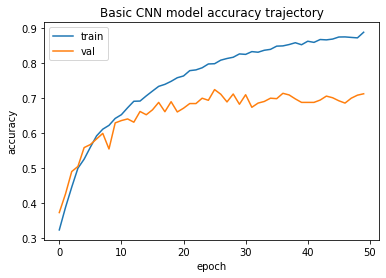

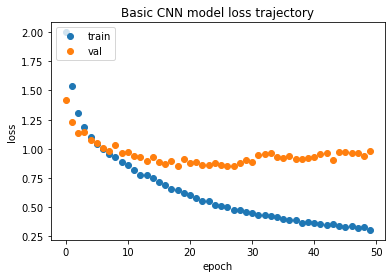

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## Testing the basic CNN model

cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.6913092732429504


# Basic CNN with VAE

In [ ]:
# Building the CNN model using sequential class
basic_cnn_model_vae = Sequential()

# Conv. block 1
basic_cnn_model_vae.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
basic_cnn_model_vae.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
basic_cnn_model_vae.add(BatchNormalization())
basic_cnn_model_vae.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model_vae.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model_vae.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model_vae.add(BatchNormalization())
basic_cnn_model_vae.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model_vae.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model_vae.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model_vae.add(BatchNormalization())
basic_cnn_model_vae.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model_vae.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model_vae.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model_vae.add(BatchNormalization())
basic_cnn_model_vae.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model_vae.add(Flatten()) # Flattens the input
basic_cnn_model_vae.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model_vae.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 84, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 84, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 84, 1, 25)         0         
                                                                 
 conv2d_13 (Conv2D)          (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 28, 1, 50)       

In [ ]:
# Compiling the model
basic_cnn_model_vae.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
with tf.device('/device:GPU:0'):
  basic_cnn_model_results_vae = basic_cnn_model_vae.fit(x_train_vae,
              y_train_vae,
              batch_size=64,
              epochs=epochs,
              validation_data=(x_valid_vae, y_valid_vae), verbose=True)

Epoch 1/50
218/218 [==============================] - 3s 9ms/step - loss: 0.9616 - accuracy: 0.6480 - val_loss: 0.6510 - val_accuracy: 0.6910
Epoch 2/50
218/218 [==============================] - 1s 7ms/step - loss: 0.7083 - accuracy: 0.6888 - val_loss: 0.5917 - val_accuracy: 0.7370
Epoch 3/50
218/218 [==============================] - 1s 6ms/step - loss: 0.6436 - accuracy: 0.7195 - val_loss: 0.5566 - val_accuracy: 0.7650
Epoch 4/50
218/218 [==============================] - 2s 7ms/step - loss: 0.5930 - accuracy: 0.7466 - val_loss: 0.5647 - val_accuracy: 0.7507
Epoch 5/50
218/218 [==============================] - 2s 7ms/step - loss: 0.5477 - accuracy: 0.7683 - val_loss: 0.5160 - val_accuracy: 0.7730
Epoch 6/50
218/218 [==============================] - 2s 8ms/step - loss: 0.5249 - accuracy: 0.7844 - val_loss: 0.5035 - val_accuracy: 0.7840
Epoch 7/50
218/218 [==============================] - 2s 8ms/step - loss: 0.4891 - accuracy: 0.7996 - val_loss: 0.4944 - val_accuracy: 0.7827
Epoch 

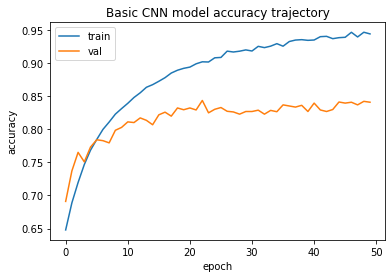

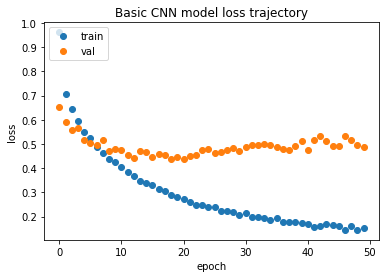

In [ ]:
# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results_vae.history['accuracy'])
plt.plot(basic_cnn_model_results_vae.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results_vae.history['loss'],'o')
plt.plot(basic_cnn_model_results_vae.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## Testing the basic CNN model

cnn_score_vae = basic_cnn_model_vae.evaluate(x_test_vae, y_test_vae, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score_vae[1])

Test accuracy of the basic CNN model: 0.8467832803726196
